# Лабораторная работа 3. Статистические гипотезы.

## Reading data and creating table of interval variational series (аналогично первой лабораторной работе)

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [166]:
path_to_data = "data.xlsx"
df = pd.read_excel(path_to_data)
df.head()
writing_score = df['writing score'].copy()
reading_score = df['reading score'].copy()

writing_score.sort_values(inplace=True)
writing_score.reset_index(inplace=True, drop=True)
reading_score.sort_values(inplace=True)
reading_score.reset_index(inplace=True, drop=True)

writing_min = min(writing_score.min(), reading_score.min())
writing_max = max(writing_score.max(), reading_score.max())
writing_elements_count = writing_score.count()
writing_range = writing_max - writing_min 
writing_intervals_count = 15
writing_len_interval = writing_range / writing_intervals_count
writing_a = [writing_min + i*writing_len_interval for i in range(writing_intervals_count + 1)]
writing_indicates = writing_score.groupby(pd.cut(writing_score, writing_a, include_lowest=True)).count()
writing_indicates.name = 'indicates'
writing_frequency = writing_indicates / writing_elements_count
writing_frequency.name = 'frequency'
writing_hist = writing_frequency / writing_len_interval
writing_hist.name = "hist"
writing_points = [(writing_a[i] + writing_a[i + 1]) / 2 for i in range(writing_intervals_count)]
writing_F = writing_frequency.cumsum()
writing_F.name = 'F'
expect_writing_score = writing_points * writing_frequency
expect_writing_score.name = "expect"
expect_square_writing_score = (writing_points * writing_frequency) * writing_points
expect_square_writing_score.name = 'expect_square'

reading_min = min(writing_score.min(), reading_score.min())
reading_max = max(writing_score.max(), reading_score.max())
reading_elements_count = reading_score.count()
reading_range = reading_max - reading_min 
reading_intervals_count = 20
reading_len_interval = reading_range / reading_intervals_count
reading_a = [reading_min + i*reading_len_interval for i in range(reading_intervals_count + 1)]
reading_indicates = reading_score.groupby(pd.cut(reading_score, reading_a, include_lowest=True)).count()
reading_indicates.name = 'indicates'
reading_frequency = reading_indicates / reading_elements_count
reading_frequency.name = 'frequency'
reading_hist = reading_frequency / reading_len_interval
reading_hist.name = "hist"
reading_points = [(reading_a[i] + reading_a[i + 1]) / 2 for i in range(reading_intervals_count)]
reading_F = reading_frequency.cumsum()
reading_F.name = 'F'
expect_reading_score = reading_points * reading_frequency
expect_reading_score.name = "expect"
expect_square_reading_score = (reading_points * reading_frequency) * reading_points
expect_square_reading_score.name = 'expect_square'

## Проверка на однородность reading_score and writing_score с помощью критерия Колмогорова Смирнова

$$ D_{n,m}= \sup_{-\infty<x<\infty} |\hat{F}_{1n}(x) - \hat{F}_{2m}(x)| \text{ - статистика Колмогорова}$$
$$ 1 - K(\lambda_{\alpha}) = \alpha $$
$$ H_0 \text{ отвергается } \Leftrightarrow  D_{n,m} > \lambda_{\alpha}\sqrt{\frac{1}{n}+\frac{1}{m}} \text {  - Критерий однородности Смирнова-Колмогорова}$$
$$ \text {Эффективная формула для расчета статистики Колмогорова из книги Г.И.Ивченко, Ю.И.Медведев введение в математическую статистику.} $$
$$ D_{n,m}^+ = \max_{ 1\le s \le n}\left( \hat{F}_{2m}(X_{(s)}) - \frac{s-1}{n} \right) $$
$$ D_{n,m}^- = \max_{ 1\le s \le n}\left( \frac{s}{n} - \hat{F}_{2m}(X_{(s)}) \right) $$

In [167]:
from scipy.stats import kstwobign
from math import sqrt
def statitic_2k(X, F_Y, n):
    p_D = max([F_Y[X[i]] - (i - 1)/n for i in range(n)])
    n_D = max([i/n - F_Y[X[i]] for i in range(n)])
    return (max(p_D, n_D))
def uniformity_ks_test(X, Y, F_X, F_Y, alpha):
    n = len(X)
    D = statitic_2k(X, F_Y, n)
    t = kstwobign.ppf(1 - alpha)
    return not D >= t*sqrt(1/len(X) + 1/len(Y))
uniformity_ks_test(reading_score, writing_score, reading_F, writing_F, 0.05)

False

Из теста Колмогорова-Смирнова следует, что выборки из разных распредлений

## Проверка на принадлежность reading score к классу равномерных распредлений с помощью критерия Колмогорова

$$ D_{n}= \sup_{-\infty<x<\infty} |F(x) - \hat{F}_{n}(x)| \text{ - статистика Колмогорова}$$
$$ 1 - K(\lambda_{\alpha}) = \alpha $$
$$ H_0 \text{ отвергается } \Leftrightarrow  \sqrt{n}*D_{n} > \lambda_{\alpha} \text {  - Критерий согласия Колмогорова}$$
$$ \text {Эффективная формула для расчета статистики Колмогорова из книги Г.И.Ивченко, Ю.И.Медведев введение в математическую статистику.} $$
$$ D_{n,m}^- = \max_{ 1\le s \le n}\left( F(X_{(s)}) - \frac{s-1}{n} \right) $$
$$ D_{n,m}^+ = \max_{ 1\le s \le n}\left( \frac{s}{n} - F(X_{(s)}) \right) $$

In [197]:
def statitic_k(X, func, n):
    n_D = max([func[X[i] - 1] - (i - 1)/n for i in range(n)])
    print(n_D)
    p_D = max([i/n - func[X[i] - 1] for i in range(n)])
    print(p_D)
    return (max(p_D, n_D))

def ks_test(X, func, alpha):
    n = len(X)
    D = statitic_k(X, func, n)
    print(D)
    t = kstwobign.ppf(1 - alpha)
    return not sqrt(n)*D >= t

In [195]:
from scipy.stats import uniform
ks_test(reading_score, uniform.cdf, 0.05)

TypeError: 'method' object is not subscriptable

Из теста Колмогорова следует, что reading не распредлено равномерно.

In [198]:
from scipy.stats import norm
ks_test(reading_score, norm.cdf(range(0, max(reading_score)), loc=reading_score.mean(), scale = reading_score.std()), 0.05)

0.03822637497478748
0.056911291103483336
0.056911291103483336


True

In [200]:
from scipy.stats import ks_1samp
ks_1samp(reading_score, norm.cdf(, range(0, 100), loc=reading_score.mean(), scale = reading_score.std()))

TypeError: rv_continuous.cdf() missing 1 required positional argument: 'x'

In [172]:
kstest(reading_score, uniform.cdf(reading_score, loc=reading_score.mean(), scale = reading_score.std()))

KstestResult(statistic=1.0, pvalue=1.9426434495222354e-119, statistic_location=1.0, statistic_sign=-1)

Text(0.5, 1.0, 'Sample distribution function')

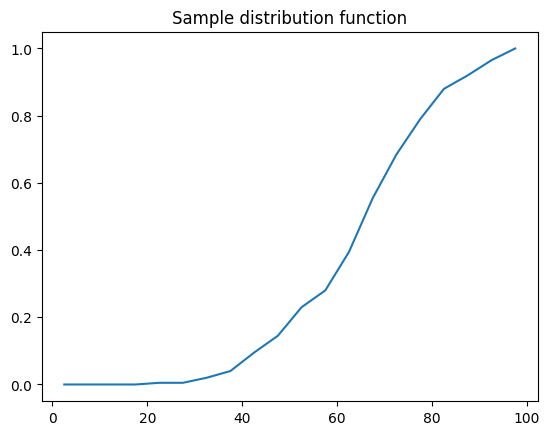

In [188]:
fig, ax = plt.subplots()
ax.plot(reading_points, reading_F.values)
ax.set_title('Sample distribution function')

16

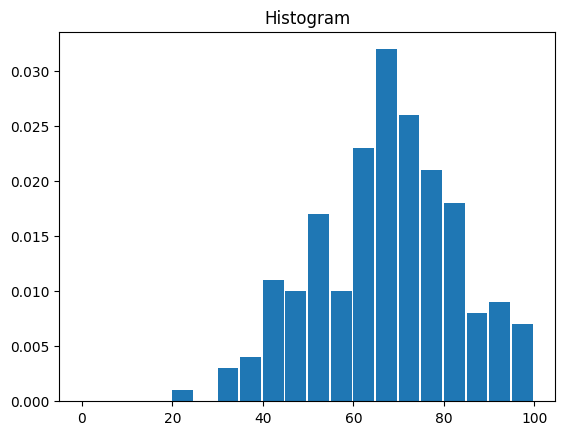

In [174]:
fig, ax = plt.subplots()
ax.bar(reading_a[:reading_intervals_count], reading_hist.values, width=reading_len_interval-0.4, align='edge')
ax.set_title('Histogram')
len(writing_a[:reading_intervals_count])

In [175]:
reading_score

0       25
1       31
2       35
3       35
4       37
      ... 
195     97
196     97
197     98
198    100
199    100
Name: reading score, Length: 200, dtype: int64

In [185]:
y = norm.cdf(range(0, max(reading_score), 1), loc=reading_score.mean(), scale = reading_score.std())
len(y)

100

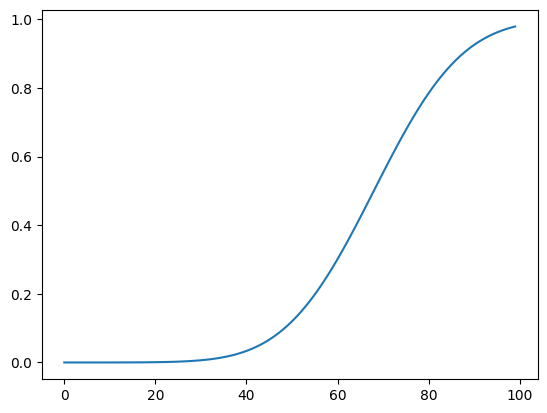

In [189]:
fig, ax = plt.subplots()
ax.plot(y)

In [178]:
y = uniform.cdf(reading_score, loc=reading_score.mean(), scale = reading_score.std())